In [1]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth, geom_bar,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import patchworklib as pw
import numpy as np
from llm_ran.benchmark.metrics import pass_at, pass_power

from llm_ran.benchmark.questions import TEST_CASES

productcatalogservice-7476c969c8-5z2sn None


<Figure size 100x100 with 0 Axes>

In [2]:
QUESTIONS_META = {
    (test_case.scenario, question.id): question
    for test_case in TEST_CASES
    for question in test_case.questions
}

levels = ["Simple Fact Finding", "Complex Fact Finding", "Reasoning"]

questions = pd.DataFrame([
    {
        "scenario": test_case.scenario,
        "question": question.id,
        "question_type": levels[question.level],
    }
    for test_case in TEST_CASES
    for question in test_case.questions
]).set_index(["scenario", "question"])
# display(questions)

In [ ]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"

mainline_models = [
    "qwen2.5:32b",
    # "qwen2.5-coder:32b",
    "sky-t1:32b",
    "qwq:32b",
]

df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[df['model'].isin(mainline_models)]
df = df.rename(columns={"chain": "agent"})
df = df.join(questions, on=["scenario", "question"])
df['question_type'] = pd.Categorical(df['question_type'], categories=levels, ordered=True)
df['model'] = pd.Categorical(df['model'], categories=mainline_models, ordered=True)

zero_to_na = ["total_tokens"]
for col in zero_to_na:
    df[col] = df[col].replace(0, np.nan)

df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'question_type'],
      dtype='object')

In [25]:
group_by = ["model", "agent", "question_type"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]
agg = {
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "correct@5": ('correct', pass_at(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct^5": ('correct', pass_power(5)),
    "pass@5": ('pass', pass_at(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass^5": ('pass', pass_power(5)),
    "execution_time": ('execution_time', 'mean'),
    "total_tokens": ('total_tokens', 'mean'),
    "num_messages": ('num_messages', 'mean'),
}
resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
display(resampled)
pivoted = resampled.melt(
    id_vars=group_by,
    value_vars=agg.keys(),
    var_name="metric",
    value_name="value",
)
# display(pivoted)

,model,agent,question_type,can_answer@5,can_answer@1,can_answer^5,correct@5,correct@1,correct^5,pass@5,pass@1,pass^5,execution_time,total_tokens,num_messages
0,qwen2.5:32b,codegen,Simple Fact Finding,0.991880,0.600000,7.776000e-02,0.998319,0.700000,0.168070,0.980390,0.528571,4.125897e-02,5.867627,3749.950000,5.400000
1,qwen2.5:32b,codegen,Complex Fact Finding,0.999989,0.880000,5.277319e-01,0.993333,0.620000,0.091613,0.992353,0.610000,8.445963e-02,3.747907,1542.750000,4.840000
2,qwen2.5:32b,codegen,Reasoning,0.666090,0.195000,2.819506e-04,0.992208,0.615000,0.087978,0.610177,0.170000,1.419857e-04,13.195296,8195.175000,7.110000
3,qwen2.5:32b,direct,Simple Fact Finding,0.998719,0.714286,1.859344e-01,0.999979,0.857143,0.462664,0.998719,0.714286,1.859344e-01,3.230677,6581.316667,6.300000
4,qwen2.5:32b,direct,Complex Fact Finding,1.000000,0.960000,8.153727e-01,0.994210,0.630000,0.099244,0.993333,0.620000,9.161328e-02,5.821231,9924.520000,8.590000
5,qwen2.5:32b,direct,Reasoning,0.998494,0.720000,1.934918e-01,0.999459,0.770000,0.270678,0.992714,0.620000,9.161328e-02,3.859086,5276.970000,6.390000
6,sky-t1:32b,codegen,Simple Fact Finding,0.654044,0.185714,2.209157e-04,0.920466,0.385714,0.008537,0.548748,0.142857,5.949902e-05,19.618834,2423.500000,4.383333
7,sky-t1:32b,codegen,Complex Fact Finding,0.965480,0.480000,2.548040e-02,0.971858,0.500000,0.031250,0.861542,0.320000,3.355443e-03,10.246890,1661.980000,4.200000
8,sky-t1:32b,codegen,Reasoning,0.248593,0.055000,5.032844e-07,0.868334,0.330000,0.003914,0.228284,0.050000,3.125000e-07,25.671083,2937.687179,3.315000
9,sky-t1:32b,direct,Simple Fact Finding,0.990188,0.585714,6.893330e-02,0.997824,0.685714,0.151606,0.980390,0.528571,4.125897e-02,9.291251,6405.813559,6.050000


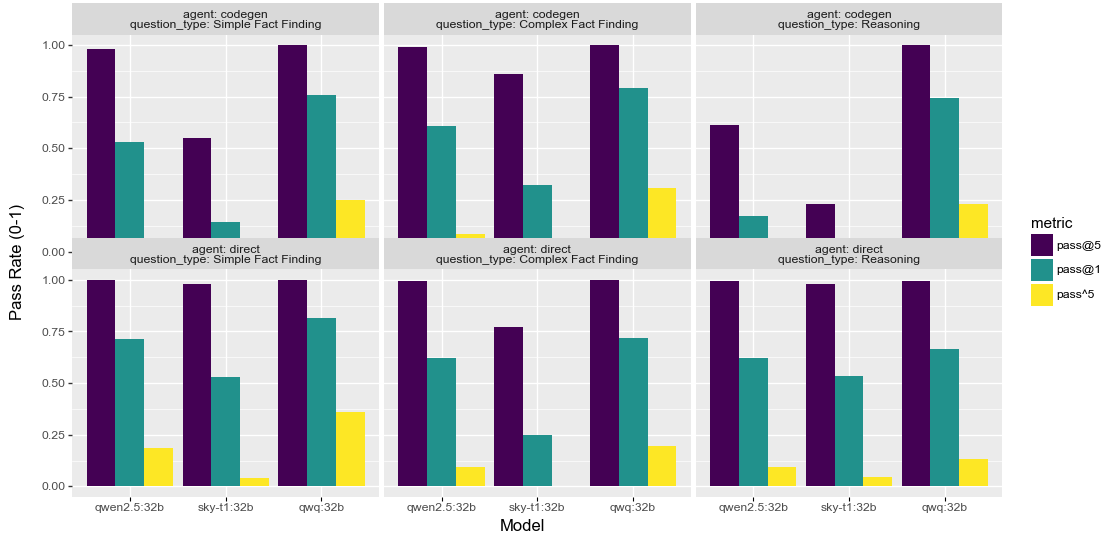

<Figure size 640x480 with 0 Axes>

In [9]:
_pass_metrics = [
    "pass@5",
    "pass@1",
    "pass^5",
]
_pass = pivoted[pivoted['metric'].isin(_pass_metrics)].copy()
_pass["metric"] = pd.Categorical(_pass["metric"], categories=_pass_metrics, ordered=True)

_g1 = (
    ggplot(_pass, aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Pass Rate (0-1)",
        fill="metric",
        # title="Pass Rate",
    )
)
_figsize = (12, 6)
_g = pw.load_ggplot(_g1, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/reasoning_performance.png", bbox_inches="tight")

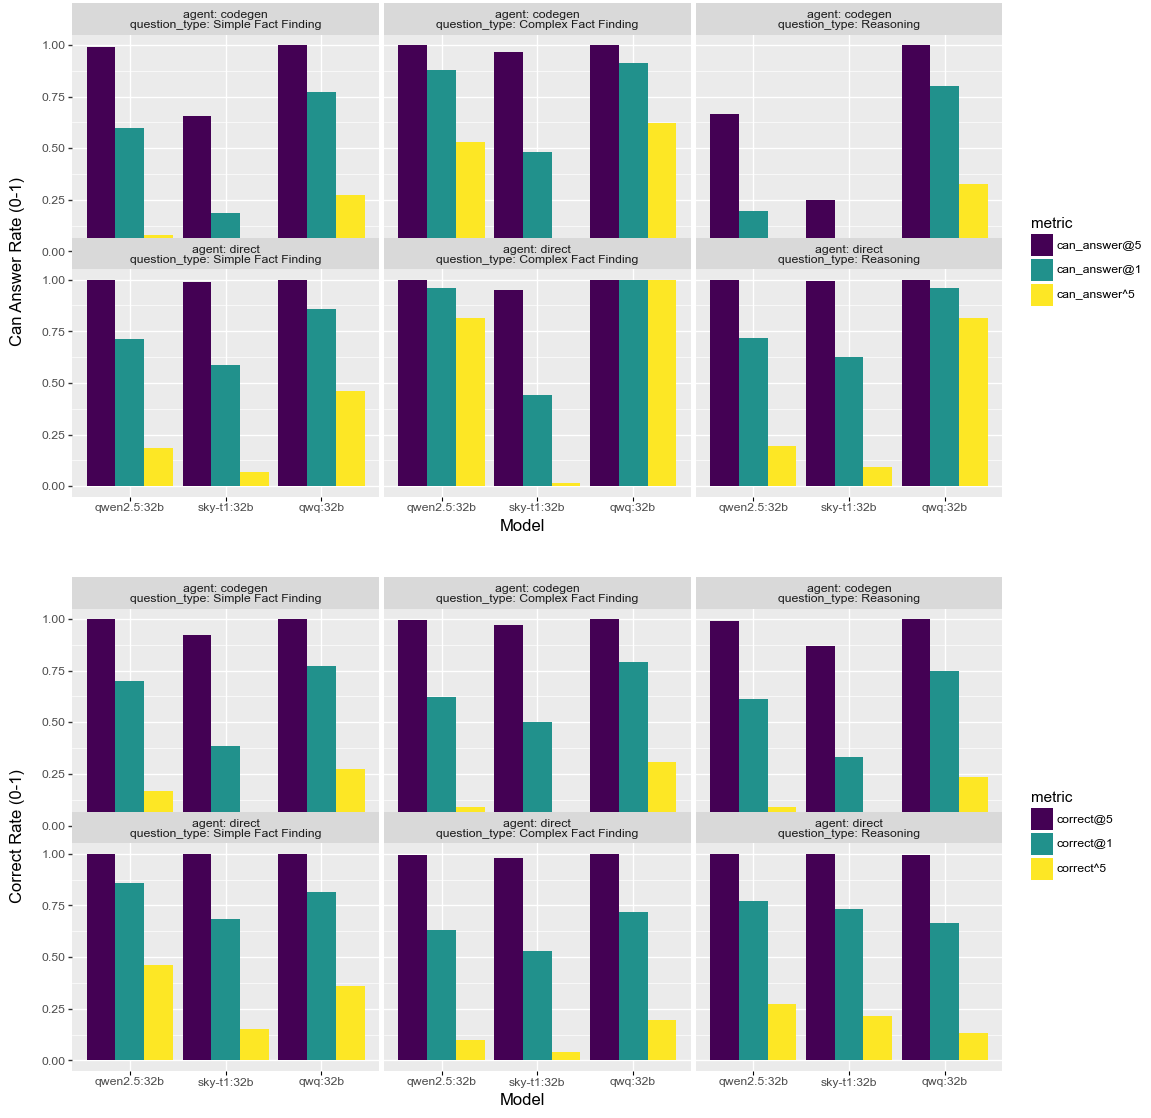

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
_can_answer_metrics = [
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
]
_can_answer = pivoted[pivoted['metric'].isin(_can_answer_metrics)].copy()
_can_answer['metric'] = pd.Categorical(_can_answer['metric'], categories=_can_answer_metrics, ordered=True)
_correct_metrics = [
    "correct@5",
    "correct@1",
    "correct^5",
]
_correct = pivoted[pivoted['metric'].isin(_correct_metrics)].copy()
_correct['metric'] = pd.Categorical(_correct['metric'], categories=_correct_metrics, ordered=True)

_g1 = (
    ggplot(_can_answer, aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Can Answer Rate (0-1)",
        fill="metric",
        # title="Can Answer Rate",
    )
)
_g2 = (
    ggplot(_correct, aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Correct Rate (0-1)",
        fill="metric",
        # title="Correct Rate",
    )
)

_figsize = (12, 6)
_g = pw.load_ggplot(_g1, figsize=_figsize) / pw.load_ggplot(_g2, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/reasoning_performance_breakdown.png", bbox_inches="tight")

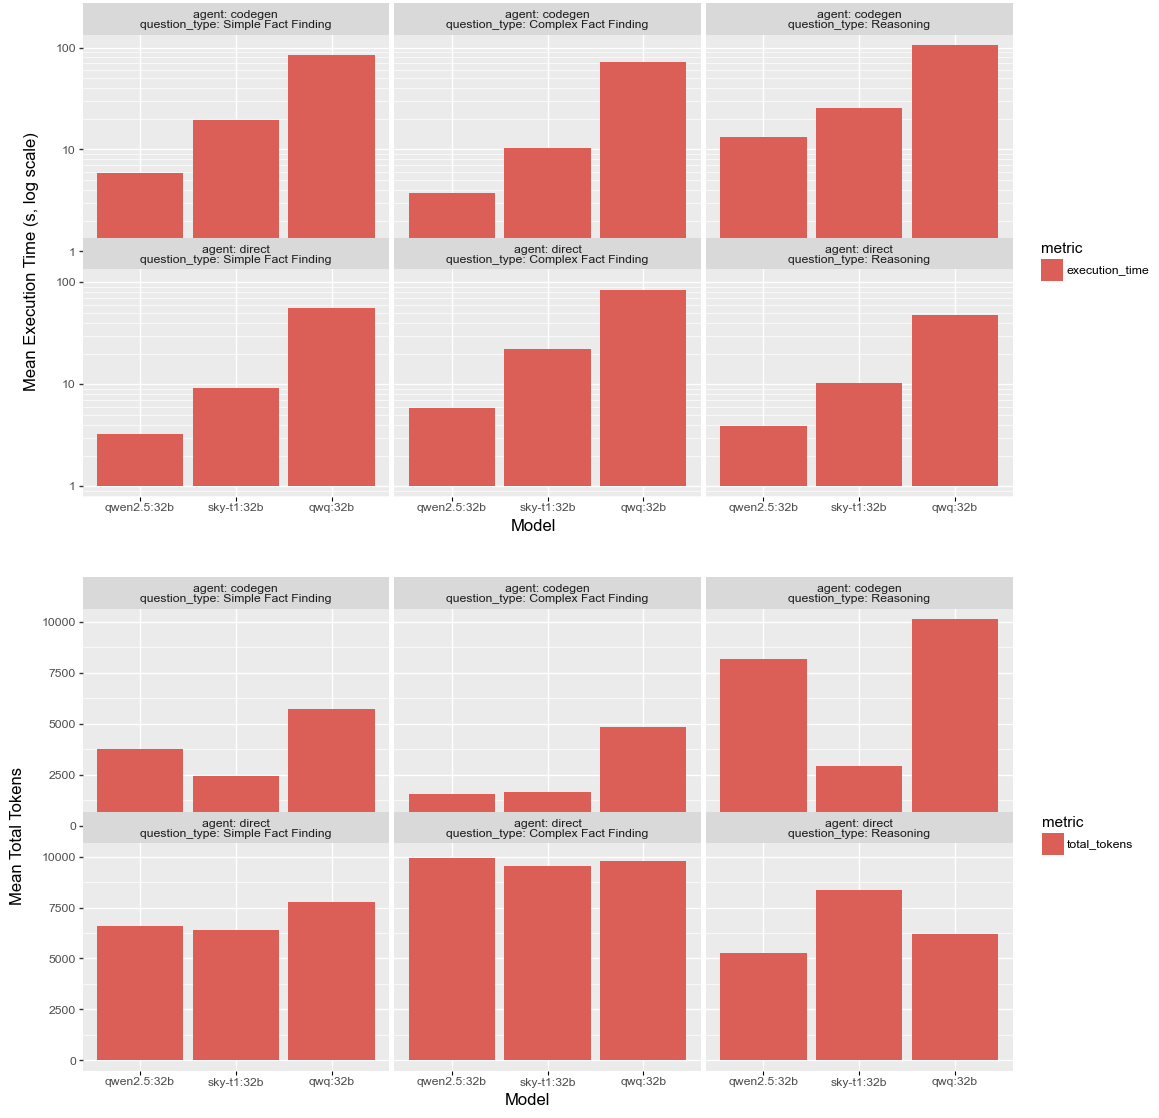

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
_g1 = (
    ggplot(pivoted[pivoted['metric'] == 'execution_time'], aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + scale_y_log10()
    + labs(
        x="Model",
        y="Mean Execution Time (s, log scale)",
        # title="Execution Time",
    )
)
_g2 = (
    ggplot(pivoted[pivoted['metric'] == 'total_tokens'], aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Mean Total Tokens",
        # title="Total Tokens",
    )
)

_figsize = (12, 6)
_g = pw.load_ggplot(_g1, figsize=_figsize) / pw.load_ggplot(_g2, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/reasoning_cost.png", bbox_inches="tight")